# PCA and GMM for Generating New Faces

In [73]:
import dataloader
import numpy as np 
import matplotlib.pyplot as plt

from IPython import display

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM




###  Load Data

In [74]:
#Load in data
data, images, labels = dataloader.loadData()

### Understand Data

In [75]:
print(type(data))
print(type(images))
print(type(labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


The Data, Images, and Labels are all arrays.

In [76]:
print(data.shape)
print(images.shape)
print(labels.shape)

(400, 4096)
(400, 64, 64)
(400,)


The Data has 400 samples. Each sample (Image) total size is 4096.<br>
The Images are 64x64 currently.<br>
There is a label associated with every Image.<br>

In [77]:
print(len(set(labels)))

40


There are 40 different Labels, meaning our dataset has 40 different subjects.

In [78]:
print(np.count_nonzero(labels==0))


10


There are 10 images for the first label along with all labels.

### Visualize the data

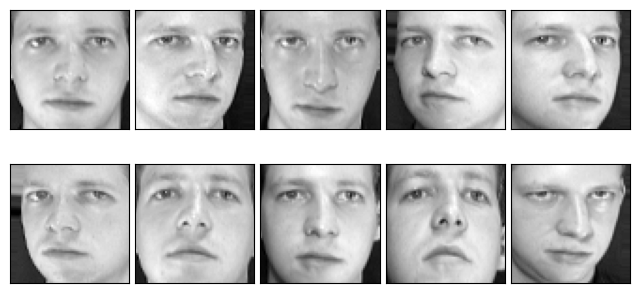

In [79]:
fig, ax = plt.subplots(2, 5, figsize=(8,4))
fig.subplots_adjust(hspace=0, wspace=0.05)
for i, axi in enumerate(ax.flat):
    axi.set(xticks=[], yticks=[])
    im = axi.imshow(images[i],cmap='gray')


These are the pictures for one subject out of 40.

# PCA 

We have 400 images, and each image has 4096 pixels total. <br>
400 < 4096 <br>
We see that the number of samples is smaller than the dimension of the image. <br>
We will use dimension reduction (PCA) to reduce the number of features.

In [80]:
scaler=MinMaxScaler()
std_data=scaler.fit_transform(data)
pca = PCA(n_components=3,whiten=True)
transformed_data = pca.fit_transform(std_data)

In [81]:
print(transformed_data.shape)

(400, 3)


### Visualize PCA

In [82]:
min = transformed_data.min()
max = transformed_data.max()
print("Minimum", min)
print("Maximum", max)

Minimum -3.2019305
Maximum 3.4947312


In [83]:
xlim = [transformed_data[:,0].min(),transformed_data[:,0].max()]
ylim = [transformed_data[:,1].min(),transformed_data[:,1].max()]
zlim = [transformed_data[:,2].min(),transformed_data[:,2].max()]

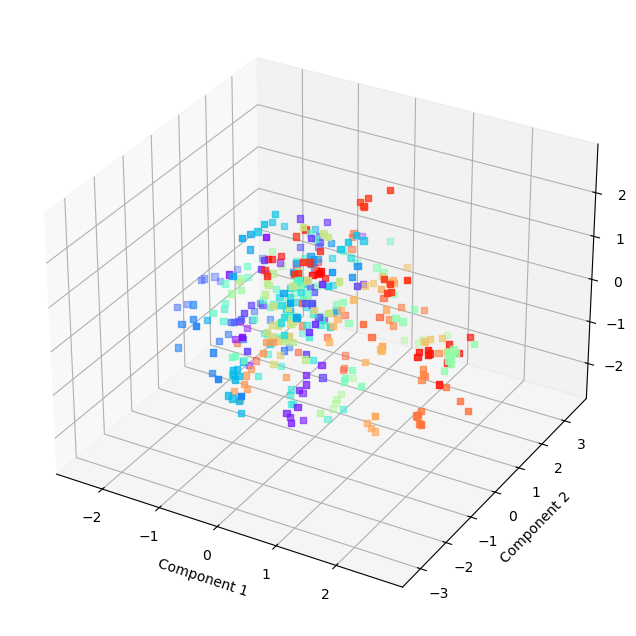

In [84]:
x = transformed_data[:,0]
y = transformed_data[:,1]
z = transformed_data[:,2]

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=labels[:,], marker='s',cmap='rainbow')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.show()

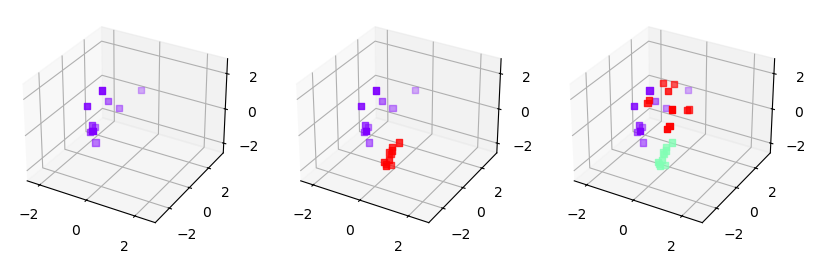

In [85]:
fig = plt.figure(figsize=(10, 10))

#Subplot 1
x = transformed_data[:10,0]
y = transformed_data[:10,1]
z = transformed_data[:10,2]
ax = fig.add_subplot(131, projection='3d')
ax.scatter(x, y, z, c=labels[:10,], marker='s',cmap='rainbow')
ax.set_xlim(xlim[0],xlim[1])
ax.set_ylim(ylim[0],ylim[1])

#Subplot 2
x = transformed_data[:20,0]
y = transformed_data[:20,1]
z = transformed_data[:20,2]
ax = fig.add_subplot(132, projection='3d')
ax.scatter(x, y, z, c=labels[:20,], marker='s',cmap='rainbow')
ax.set_xlim(xlim[0],xlim[1])
ax.set_ylim(ylim[0],ylim[1])

#Subplot 3
x = transformed_data[:30,0]
y = transformed_data[:30,1]
z = transformed_data[:30,2]
ax = fig.add_subplot(133, projection='3d')
ax.scatter(x, y, z, c=labels[:30,], marker='s',cmap='rainbow')
ax.set_xlim(xlim[0],xlim[1])
ax.set_ylim(ylim[0],ylim[1])

plt.show()

Its easier to see in the above plots, but each time we add a class, a new cluster appeaers on our plot. 

#### Generate new faces using PCA

In [86]:
pca2 = PCA(n_components=100,whiten=True)
new_transformed_data = pca2.fit_transform(std_data)

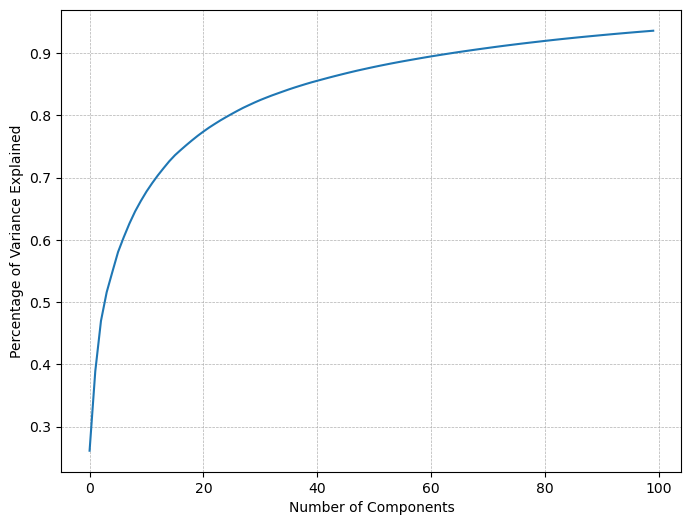

In [87]:
y=np.cumsum(pca2.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(0, 100), y, linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Variance Explained')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

In [88]:
n = 0
while n < len(y) and y[n] < 0.80:
    n += 1

print("Smallest value of n_component:",n)

Smallest value of n_component: 25


In [89]:
pca3 = PCA(n_components=25,whiten=True)
new_transformed_data = pca3.fit_transform(std_data)

In [90]:
mean=pca3.mean_
variance=pca3.explained_variance_
components=pca3.components_
components.shape

(25, 4096)

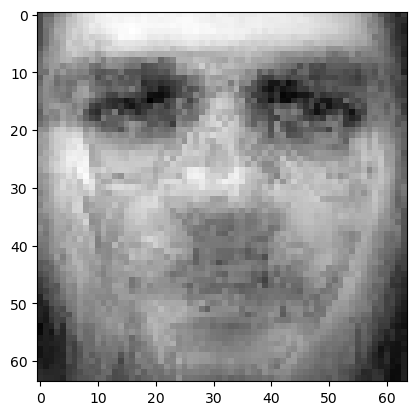

In [91]:
# plot the mean image from pca
plt.imshow(mean.reshape(64,64), cmap='gray')

This is the mean image, meaning the average pixel intensity for the whole dataset. 

In [92]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 25):
    ax.imshow(components[n].reshape(64,64), cmap='gray')    
    ax.axis('off')
    ax.set_title(n)
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.2) 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

These faces are created by using the principal components.<br>
PCA is not great at generating new faces. 

# GMM to help generate better faces

PCA captures linear relationships while GMM models the overall distribution of the data as a mixture of gaussian distributions. It can capture both linear and non-linear relationships, so it will be better at generating faces rather than blurry objects.

Optimal PCA:

In [ ]:
pca = PCA(n_components=25,whiten=True)
gmm_data = pca.fit_transform(std_data)

In [93]:
gmm_data.shape

(400, 25)

The Akaike Information Criterion (AIC) balances goodness of fit with model complexity, so we'd like to use the GMM with a minimum AIC value.

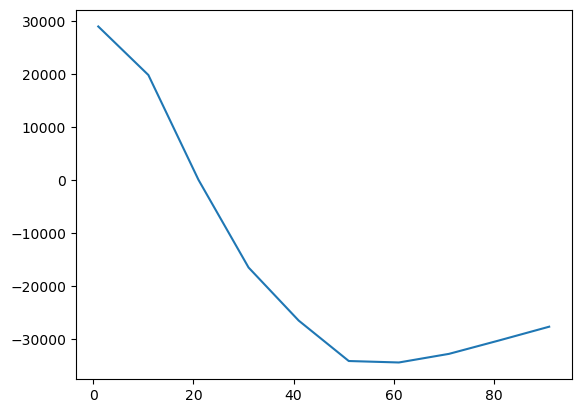

In [94]:
n_components = np.arange(1, 100, 10)

models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(gmm_data).aic(gmm_data) for model in models]
plt.plot(n_components, aics);

In [ ]:
best_n_components = n_components[np.argmin(aics)]
print("The number of components ideal for this GMM is: " , best_n_components)

The number of components ideal for this GMM is:  61


In [ ]:
gmm = GMM(n_components=best_n_components,covariance_type="full")
gmm.fit(gmm_data)

GaussianMixture(n_components=61)

### Generate Faces

50 new faces will be created

In [ ]:
new_data, _ = gmm.sample(50)
new_data.shape

(50, 25)

In [ ]:
faces_new = pca.inverse_transform(new_data)
faces_new=faces_new.reshape(50,64,64)

Here are the 50 new faces:

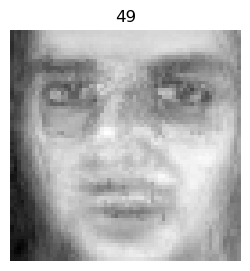

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 50):
    ax.imshow(faces_new[n], cmap='gray')    
    ax.axis('off')
    ax.set_title(n)
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.2) 

Standardize faces:

In [ ]:
scaler = StandardScaler()
std_data=scaler.fit_transform(data)
std_faces=scaler.transform(faces_new.reshape(50,-1))


# SVM Classification

In [ ]:
svm = SVC(kernel='rbf', C=1.0,random_state=42)
svm.fit(std_data,labels)

SVC(random_state=42)

In [ ]:
facepredict = svm.predict(std_faces)
facepredict

array([11,  8, 20, 31, 12, 24, 24, 36, 21, 21, 27, 13, 29, 29,  4,  9, 36,
       36, 10, 24, 20,  0,  4, 34, 39, 39,  7,  5,  5, 18, 23, 28, 38, 25,
       37, 26, 14, 27, 27, 17, 17, 30,  1, 14, 14, 14, 17, 35, 12,  0])

Lets see how much our new faces look like the faces they are classified as:

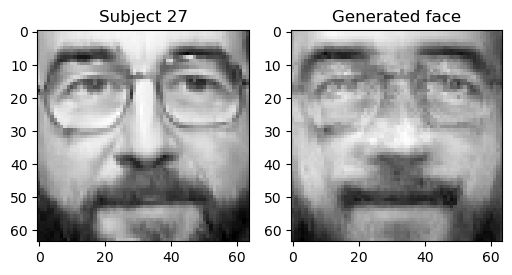

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(6, 3))

for n in range(0, 50):
    num = facepredict[n] * 10
    ax[0].imshow(images[num],cmap='gray')
    ax[1].imshow(faces_new[n],cmap='gray')
    ax[0].set_title(f"Subject {facepredict[n]}")  # Set the title for the first subplot
    ax[1].set_title(f"Generated face")  # Set the title for the first subplot

    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(1) 